In [1]:
#Loading necessary libraries
!pip install -U sympy
!pip install diffusers peft transformers accelerate datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 70.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cud

In [2]:
#I used google drive for file upload
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [18]:
#importing libraries
from pathlib import Path
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import login
from peft import LoraConfig
import torch
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from peft.utils import get_peft_model_state_dict
from diffusers.utils import convert_state_dict_to_diffusers
from datasets import load_dataset
from functools import partial
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pydantic import BaseModel
from diffusers.training_utils import compute_snr
import torch.nn.functional as F
import torchvision.transforms as transforms

In [19]:
#Hugging face token
HF_TOKEN = "You can get a hugging face token from https://huggingface.co/docs/hub/security-tokens"
login(token=HF_TOKEN)

In [20]:
def get_models(model_name, dtype=torch.float16):
    tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(dtype=dtype)
    vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(dtype=dtype)
    scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")
    unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(dtype=dtype)
    return tokenizer, text_encoder, vae, scheduler, unet

In [21]:
class Caillou(Dataset):
    def __init__(self, data_dir: Path, tokenizer: CLIPTokenizer):
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "index.csv")
        self.tokenizer = tokenizer

        # Size all images to 512x512
        self.train_transforms = transforms.Compose(
            [
                transforms.Resize((512, 512)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                # mean and std for RGB
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.data_dir / "images" / self.df.iloc[idx]["image"]
        image = Image.open(image_path).convert("RGB")
        image = self.train_transforms(image)

        input_ids = self.tokenizer(
            self.df.iloc[idx]["short_prompt"],
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0]

        return {"pixel_values": image, "input_ids": input_ids}

In [22]:
# Prepare for training
def setup_models_for_training(model_name, rank: int=128):
    tokenizer, text_encoder, vae, scheduler, unet = get_models(model_name)

    # freeze
    for m in (unet, text_encoder, vae):
        for p in m.parameters():
            p.requires_grad = False

    # LoRA konfiguration
    unet_lora_config = LoraConfig(
        r=rank,
        lora_alpha=rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

    unet.add_adapter(unet_lora_config)

    # Turn trainableweights to float32
    for p in unet.parameters():
        if p.requires_grad:
            p.data = p.to(dtype=torch.float32)

    return tokenizer, text_encoder, vae, scheduler, unet

def get_lora_params(unet):
    return [p for p in filter(lambda p: p.requires_grad, [p for p in unet.parameters()])]


In [23]:
# Training setup
class TrainingConfig(BaseModel):
    train_steps: int = 100
    lr: float = 1e-5
    batch_size: int = 4
    accumulation_steps: int = 2
    rank: int = 128
    max_grad_norm: float = 1.0
    pretrained_name: str = "runwayml/stable-diffusion-v1-5"
    data_dir: str = "/content/drive/MyDrive/caillou"
    snr_gamma: float = -1
    seed: int = -1


<ipython-input-24-e48d15ba7fc1>:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

configs: train_steps=1000 lr=1e-05 batch_size=4 accumulation_steps=2 rank=62 max_grad_norm=1.0 pretrained_name='runwayml/stable-diffusion-v1-5' data_dir='/content/drive/MyDrive/caillou' snr_gamma=5.0 seed=42
epochs: 27
steps per epoch: 38
total steps: 1000
accumulation steps: 2
total batch size: 8
lr: 8e-05


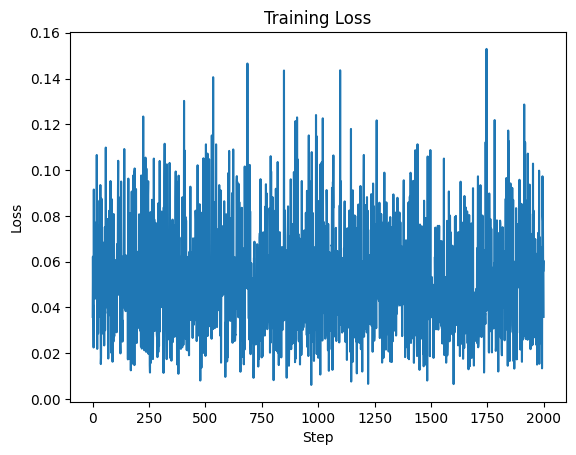

-rw-r--r-- 1 root root 48M Feb  6 01:13 ./out/pytorch_lora_weights.safetensors


In [24]:
# Train function
def train(
    tokenizer: CLIPTokenizer,
    text_encoder: CLIPTextModel,
    vae: AutoencoderKL,
    scheduler: DDPMScheduler,
    unet: UNet2DConditionModel,
    config: TrainingConfig,
    device = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    lora_params = get_lora_params(unet)

    text_encoder.to(device).eval()
    vae.to(device).eval()
    unet.to(device).train()

    # DataLoader
    train_dataset = Caillou(Path(config.data_dir), tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    steps_per_epoch = math.ceil(len(train_dataloader) / config.accumulation_steps)
    epochs = math.ceil(config.train_steps / steps_per_epoch)

    lr = config.lr * config.accumulation_steps * config.batch_size
    optimizer = torch.optim.AdamW(lora_params, lr=lr)

    scaler = torch.cuda.amp.GradScaler()

    global_step = 0
    progress_bar = tqdm(range(config.train_steps), desc="Steps")

    print(f"configs: {config}")
    print(f"epochs: {epochs}")
    print(f"steps per epoch: {steps_per_epoch}")
    print(f"total steps: {config.train_steps}")
    print(f"accumulation steps: {config.accumulation_steps}")
    print(f"total batch size: {config.batch_size * config.accumulation_steps}")
    print(f"lr: {lr}")

    losses = []
    for _ in range(epochs):
        for step, batch in enumerate(train_dataloader):
            bs = batch["input_ids"].shape[0]

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                # encode prompts
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"].to(device), return_dict=False)[0]

                # Choose random timestamp
                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bs,)).long().to(device)

                # Take picture latent via VAE
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"].to(device)).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor

                noise = torch.randn_like(latents)
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)

                # UNet guess for noise
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                # MSE, SNR weighted loss
                if config.snr_gamma > 0:
                    snr = compute_snr(scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, config.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0]
                    mse_loss_weights = mse_loss_weights / snr
                    loss = F.mse_loss(noise_pred, noise, reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="mean")

            global_step += 1
            scaler.scale(loss).backward()

            if global_step % config.accumulation_steps == 0:
                if config.max_grad_norm > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(lora_params, config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                progress_bar.update(1)

            losses.append(loss.item())
            progress_bar.set_postfix({"loss": losses[-1]})
            if global_step / config.accumulation_steps >= config.train_steps:
                break

    return {"losses": losses}

# clear cache
try:
    del models, pipe
    import gc; gc.collect()
    torch.cuda.empty_cache()
except Exception as e:
    print(e)

# Training config
config = TrainingConfig()
config.lr = 1e-5
config.rank = 62
config.train_steps = 1000
config.snr_gamma = 5.0
config.seed = 42

torch.manual_seed(config.seed)

# getting model ready with lora
models = setup_models_for_training(config.pretrained_name, rank=config.rank)

# Run the training
outputs = train(*models, config)
plt.plot(outputs["losses"])
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

# Set and save lora weights
unet = models[-1]
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))
StableDiffusionPipeline.save_lora_weights(
    save_directory="./out",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)

!ls -l -h ./out/pytorch_lora_weights.safetensors


df = pd.read_csv(Path(config.data_dir) / "index.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_inference_steps = 35

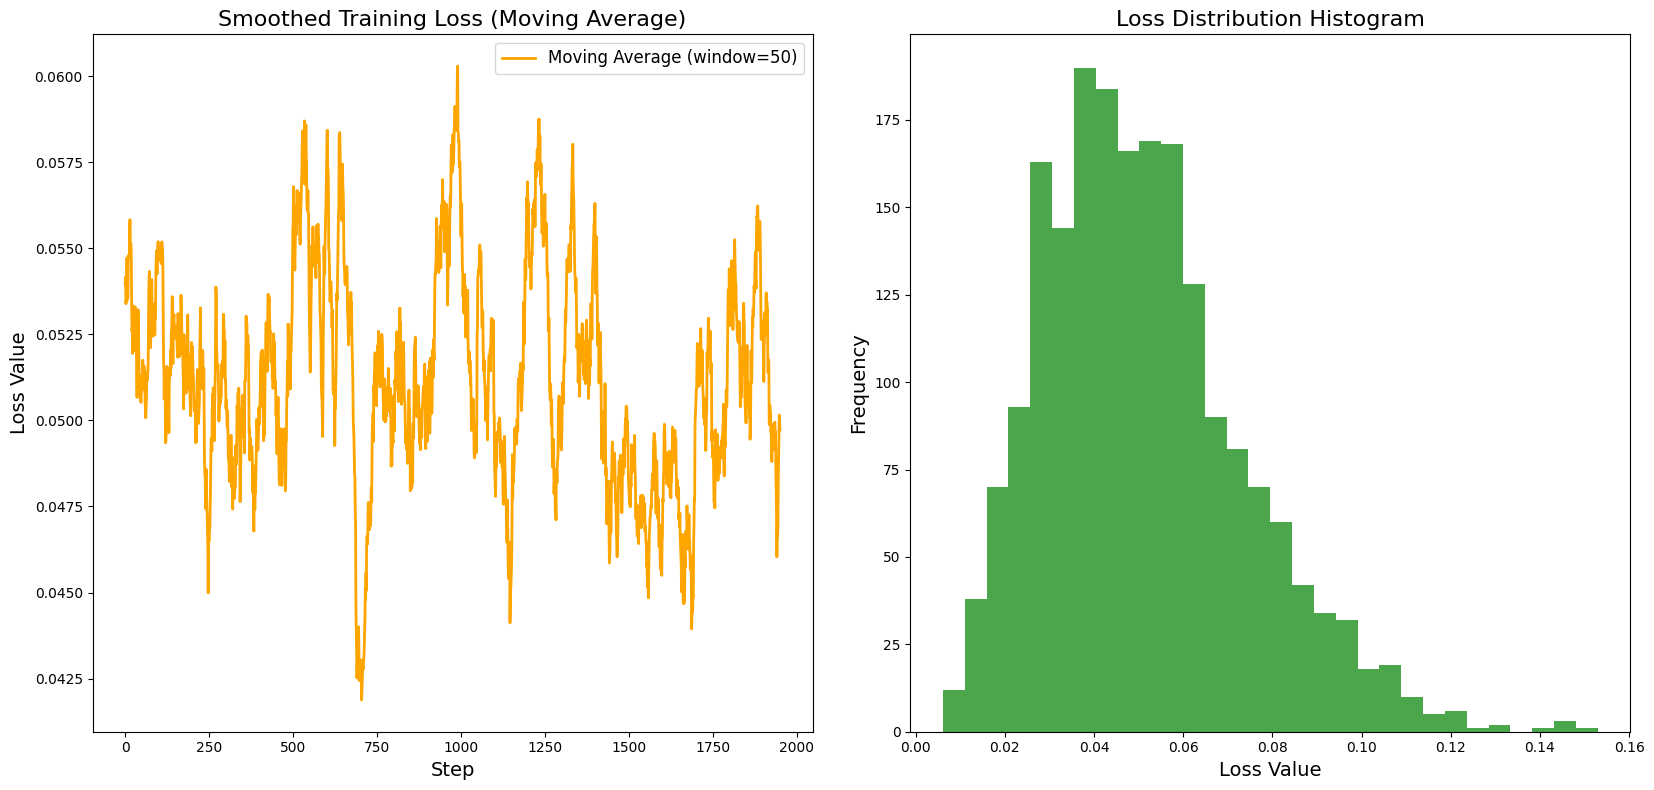

In [33]:

losses = outputs["losses"]

plt.figure(figsize=(24, 8))



# Moving Average Loss Curve
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50
losses_ma = moving_average(losses, window_size)

plt.subplot(1, 3, 2)
plt.plot(losses_ma, color="orange", label=f"Moving Average (window={window_size})", linewidth=2)
plt.xlabel("Step", fontsize=14)
plt.ylabel("Loss Value", fontsize=14)
plt.title("Smoothed Training Loss (Moving Average)", fontsize=16)
plt.legend(fontsize=12)

# Loss Distribution Histogram
plt.subplot(1, 3, 3)
plt.hist(losses, bins=30, color="green", alpha=0.7)
plt.xlabel("Loss Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Loss Distribution Histogram", fontsize=16)

plt.tight_layout()
plt.show()

In [26]:
def generate(pipeline, prompt, seed):
    generator = torch.Generator(device=device).manual_seed(seed)
    return pipeline(prompt, num_inference_steps=num_inference_steps, generator=generator).images[0]

# Production with original model
pipe = DiffusionPipeline.from_pretrained(
    config.pretrained_name,
    torch_dtype=torch.float16
).to(device)



# generation with lora weights
pipe.load_lora_weights("./out/pytorch_lora_weights.safetensors")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

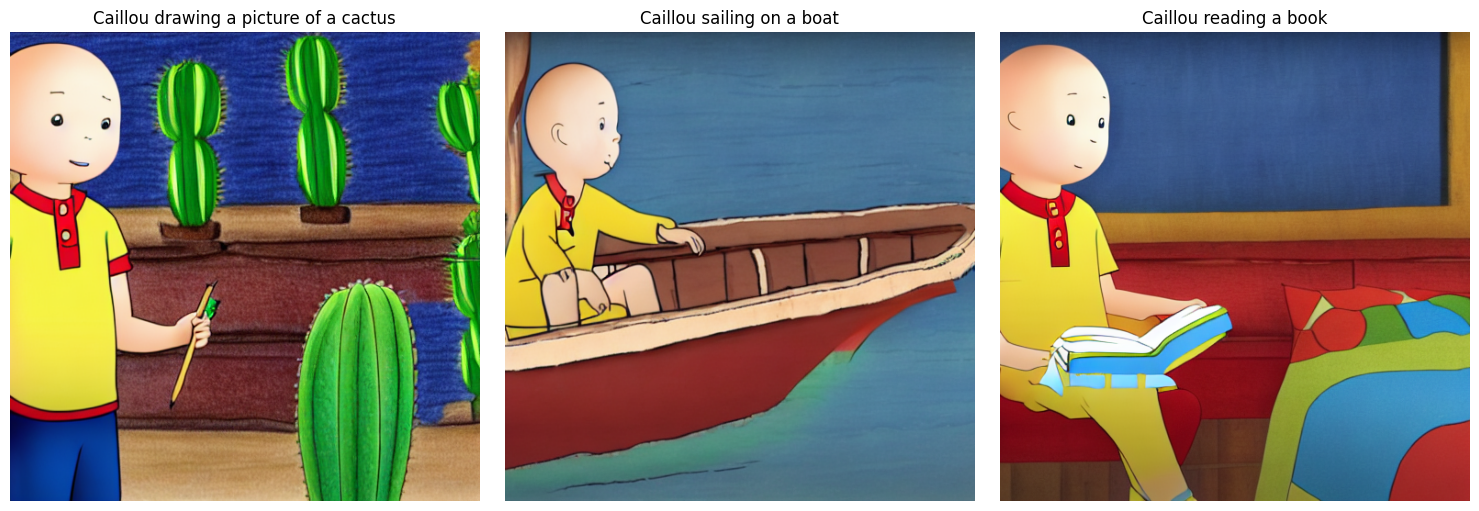

In [17]:
# Define 3 new prompts
new_prompts = [
    "Caillou drawing a picture of a cactus",
    "Caillou sailing on a boat",
    "Caillou reading a book"
]

new_images = []
seed = 3
for prompt in new_prompts:
    img = generate(pipe, prompt, seed)
    new_images.append(img)

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, img in enumerate(new_images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(new_prompts[i])
plt.tight_layout()
plt.show()